# Classification - Doc2Vec

This notebook discusses Multi-label classificaon methods for the [academia.stackexchange.com](https://academia.stackexchange.com/) data dump in [Doc2Vec](https://radimrehurek.com/gensim_3.8.3/models/doc2vec.html) representation.

## Table of Contents
* [Data import](#data_import)
* [Data preparation](#data_preparation)
* [Methods](#methods)
* [Evaluation](#evaluation)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from joblib import dump, load
from pathlib import Path
from academia_tag_recommender.definitions import MODELS_PATH
from academia_tag_recommender.classifier import Classifier, available_classifier_paths

DATA_FOLDER = Path(MODELS_PATH) / 'classifier' / 'multi-label'
RANDOM_STATE = 0

<a id='data_import'/>

## Data import

In [2]:
from academia_tag_recommender.data import documents
from academia_tag_recommender.test_train_data import get_y, get_test_train_data

def get_X():
     return np.vstack([document.text for document in documents])

y = get_y()
X_train, X_test, y_train, y_test = get_test_train_data(get_X(), y, scale=False)
print('Train set with shape ', X_train.shape)
print('Test set with shape', X_test.shape)

Train set with shape  (24812, 1)
Test set with shape (8270, 1)


<a id='data_preparation'/>

## Data Preparation

In [3]:
from academia_tag_recommender.embedded_data import doc2vec

In [4]:
from academia_tag_recommender.preprocessing_definition import PreprocessingDefinition
preprocessing = PreprocessingDefinition('doc2vec', 'basic', 'basic', 'english', '1,1', 'None')
paths = available_classifier_paths('doc2vec')

def create_classifier(classifier, name, vector_size=100):
    path = [path for path in paths if name in path.name]
    if len(path) > 0:
        clf = load(path[0])
    else:
        clf = Classifier(classifier, preprocessing, name)
        X_train_, X_test_ = doc2vec(X_train, X_test, vector_size=vector_size)
        clf.fit(X_train_, y_train)
        clf.score(X_test_, y_test)
        clf.save('doc2vec')
    print('Training: {}s'.format(clf.training_time))
    print('Test: {}s'.format(clf.test_time))
    clf.evaluation.print_stats()

<a id='methods'/>

## Methods

* [Problem Transformation](#problem_transformation)
* [Algorithm Adaption](#algorithm_adaption)
* [Ensembles](#ensembles)

<a id='problem_transformation'/>

### Problem Transformation

- [DecisionTreeClassifier](#decisiontree)
- [KNeighborsClassifier](#kNN)
- [MLPClassifier](#mlp)
- [MultioutputClassifier](#multioutput)
- [Classwise Classifier](#classwise)
- [Classifier Chain](#chain)
- [Label Powerset](#label_powerset)

<a id='decisiontree'/>

**DecisionTreeClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

In [5]:
from sklearn.tree import DecisionTreeClassifier

create_classifier(DecisionTreeClassifier(random_state=RANDOM_STATE), 'DecisionTreeClassifier')

Training: 83.91892623901367s
Test: 0.06732368469238281s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.024494367720995353     0.003022974607013301     0.10214832728738413      0.10390769850866585      0.09458033435058828      
micro                                                            0.1007610627534977       0.10545142366576048      0.10305290142158005      
macro                                                            0.03316841584152066      0.034828983422270976     0.033890567332971674     


<a id='kNN'/>

**KNeighborsClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

In [6]:
from sklearn.neighbors import KNeighborsClassifier

create_classifier(KNeighborsClassifier(), 'KNeighborsClassifier')

Training: 1.0539038181304932s
Test: 91.72107815742493s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013229173295996946     0.04812575574365175      0.18002821442966546      0.08679766223297058      0.11069729947601774      
micro                                                            0.5280024891101431       0.08093671006820241      0.14035813241801415      
macro                                                            0.2223102324006733       0.026224475571490345     0.04306076762630737      


<a id='mlp'/>

**MLPClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)

In [7]:
from sklearn.neural_network import MLPClassifier

create_classifier(MLPClassifier(random_state=RANDOM_STATE), 'MLPClassifier')

Training: 133.49803471565247s
Test: 0.06568408012390137s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012938967733723668     0.06517533252720677      0.36682328554154436      0.22337363966142687      0.25750420948123487      
micro                                                            0.5381294964028777       0.2140506510230362       0.30627495137680416      
macro                                                            0.35603445099836184      0.1447573722458525       0.19262547484156498      


<a id='multioutput'/>

**MultioutputClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html#sklearn.multioutput.MultiOutputClassifier)

MultiouputClassifier transforms sklearn classifier into classifiers capable of Binary Relevence.

In [8]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC

create_classifier(MultiOutputClassifier(LinearSVC(random_state=RANDOM_STATE)), 'MultioutputClassifier(LinearSVC)')

Training: 623.0082957744598s
Test: 0.8957927227020264s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012690765608095208     0.057557436517533256     0.2197190073127195       0.1163442160419186       0.14222012838699657      
micro                                                            0.6387987012987013       0.11260552296465876      0.19146089283542148      
macro                                                            0.25422585300796646      0.04268305574694436      0.06533095625591985      


In [9]:
from sklearn.linear_model import LogisticRegression

create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)')

Training: 30.143357753753662s
Test: 0.8473837375640869s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013390822885508814     0.054050785973397825     0.2778443476448314       0.1881640467553406       0.20265507583971468      
micro                                                            0.4953105196451204       0.1863881337339629       0.2708528260040891       
macro                                                            0.3126818162847695       0.12397315366082585      0.16719168424213185      


<a id='classwise'/>

**Classwise Classifier**

In [10]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score

scorer = make_scorer(accuracy_score)

In [11]:
from academia_tag_recommender.classwise_classifier import ClasswiseClassifier, ClassifierOption

classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]}),
                      ClassifierOption(LogisticRegressionCV(Cs=[0.1, 0.5, 1, 5, 10], random_state=RANDOM_STATE, max_iter=2000, scoring=scorer))]
                      #ClassifierOption(RandomForestClassifier(random_state=RANDOM_STATE))]

#create_classifier(ClasswiseClassifier(classifier_options), 'ClasswiseClassifier')

<a id='chain'/>

**Classifier Chain** [source](http://scikit.ml/api/skmultilearn.problem_transform.cc.html#skmultilearn.problem_transform.ClassifierChain)

<cite>[Read et al., 2011][1]</cite>

[1]: https://doi.org/10.1007/s10994-011-5256-5

In [12]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.svm import LinearSVC

create_classifier(ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)), 'ClassifierChain(LinearSVC)')

Training: 459.90921568870544s
Test: 2.6340551376342773s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012697129765162605     0.060701330108827084     0.2704621792288056       0.14851471180975415      0.1792924320070632       
micro                                                            0.6016813450760609       0.1433681499499213       0.2315602973462235       
macro                                                            0.29813914637148076      0.06785580938982887      0.09780396353909686      


In [13]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
create_classifier(ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)), 'ClassifierChain(LogisticRegression)')

Training: 91.8856430053711s
Test: 2.6749398708343506s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013390822885508814     0.058887545344619104     0.3027030968651994       0.20567110036275696      0.2232050624157271       
micro                                                            0.4956633849038912       0.2016979062336052       0.28672158378250107      
macro                                                            0.31460152068765435      0.13009102248320514      0.17345468678954087      


<a id='label_powerset'/>

**Label Powerset** [source](http://scikit.ml/api/skmultilearn.problem_transform.lp.html#skmultilearn.problem_transform.LabelPowerset)

In [14]:
from skmultilearn.problem_transform import LabelPowerset

create_classifier(LabelPowerset(classifier=LinearSVC(random_state=RANDOM_STATE)), 'LabelPowerset(LinearSVC)')

Training: 1305.3239686489105s
Test: 1.4696054458618164s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.020982625851206006     0.017775090689238212     0.2380229746070133       0.18490931076178957      0.1900430893840809       
micro                                                            0.19444020161906217      0.1821433681499499       0.18809101654846336      
macro                                                            0.10226068049830368      0.09510495341357725      0.09685274576879745      


In [15]:
# Does not finish
#create_classifier(LabelPowerset(classifier=LogisticRegression(random_state=RANDOM_STATE)), 'LabelPowerset(LogisticRegression)')

<a id='Algorithm Adaption'/>

### Algorithm Adaption

- [MLkNN](#mlknn)
- [MLARAM](#mlaram)

<a id='mlknn'/>

**MLkNN** [source](http://scikit.ml/api/skmultilearn.adapt.mlknn.html#multilabel-k-nearest-neighbours)

> Firstly, for each test instance, its k nearest neighbors in the training set are identified. Then, according to statistical information gained from the label sets of these neighboring instances, i.e. the number of neighboring instances belonging to each possible class, maximum a posteriori (MAP) principle is utilized to determine the label set for the test instance.
<cite>[Zhang & Zhou, 2007][1]</cite>

[1]: https://doi.org/10.1016/j.patcog.2006.12.019

In [16]:
from skmultilearn.adapt import MLkNN

#create_classifier(MLkNN(), 'MLkNN')

<a id='mlaram'/>

**MLARAM** [source](http://scikit.ml/api/skmultilearn.adapt.mlaram.html#skmultilearn.adapt.MLARAM)

> an extension of fuzzy Adaptive Resonance Associative Map (ARAM) – an Adaptive Resonance Theory (ART)based neural network. It aims at speeding up the classification process in the presence of very large data.
<cite>[F. Benites & E. Sapozhnikova, 2015][7]</cite>

[7]: https://doi.org/10.1109/ICDMW.2015.14

In [17]:
from skmultilearn.adapt import MLARAM

#create_classifier(MLARAM(), 'MLARAM')

<a id='ensembles'/>

### Ensembles

- [RAkELo](#rakelo)
- [RAkELd](#rakeld)
- [MajorityVotingClassifier](#majority_voting)
- [LabelSpacePartitioningClassifier](#label_space)

<a id='rakelo'/>

**RAkELo** [source](http://scikit.ml/api/skmultilearn.ensemble.rakelo.html#skmultilearn.ensemble.RakelO)

> Rakel: randomly breaking the initial set of labels into a number of small-sized labelsets, and employing [Label powerset] to train a corresponding multilabel classifier.
<cite>[Tsoumakas et al., 2011][1]</cite>


> Divides the label space in to m subsets of size k, trains a Label Powerset classifier for each subset and assign a label to an instance if more than half of all classifiers (majority) from clusters that contain the label assigned the label to the instance.
<cite>[skmultilearn][2]</cite>


[1]: https://doi.org/10.1109/TKDE.2010.164
[2]: http://scikit.ml/api/skmultilearn.ensemble.rakelo.html#skmultilearn.ensemble.RakelO

In [18]:
from skmultilearn.ensemble import RakelO
from sklearn.svm import LinearSVC

create_classifier(RakelO(
    base_classifier=LinearSVC(random_state=RANDOM_STATE),
    model_count=y_train.shape[1]
), 'RakelO(LinearSVC)')

Training: 2949.061872959137s
Test: 119.29928040504456s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012753134347355692     0.05465538089480049      0.19113260781942765      0.0968520757758968       0.12092099959693671      
micro                                                            0.6538461538461539       0.09405255878284924      0.16444981862152358      
macro                                                            0.17735594606748614      0.0243099427330777       0.03854762455660733      


In [19]:
from sklearn.linear_model import LogisticRegression

create_classifier(RakelO(
    base_classifier=LogisticRegression(random_state=RANDOM_STATE),
    model_count=y_train.shape[1]
), 'RakelO(LogisticRegression)')

Training: 357.3322033882141s
Test: 122.45103430747986s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013414370266658182     0.05489721886336155      0.27741942447149076      0.1887807335751713       0.2029578709681472       
micro                                                            0.4929968454258675       0.1863404397386369       0.2704554894088329       
macro                                                            0.3107632428779605       0.12484240713810972      0.16785803412811978      


<a id='rakeld'/>

**RAkELd** [source](http://scikit.ml/api/skmultilearn.ensemble.rakeld.html#skmultilearn.ensemble.RakelD)

>Divides the label space in to equal partitions of size k, trains a Label Powerset classifier per partition and predicts by summing the result of all trained classifiers.
<cite>[skmultilearn][3]</cite>

[3]: http://scikit.ml/api/skmultilearn.ensemble.rakeld.html#skmultilearn.ensemble.RakelD

In [20]:
from skmultilearn.ensemble import RakelD

create_classifier(RakelD(base_classifier=LinearSVC(random_state=RANDOM_STATE)), 'RakelD(LinearSVC)')

Training: 969.0803124904633s
Test: 37.46899127960205s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.0128479602876599       0.054050785973397825     0.1840107675476478       0.09382103990326479      0.11673825838275656      
micro                                                            0.6290162305399138       0.09057089712405209      0.15834236638038857      
macro                                                            0.19164613012327392      0.024022989101130834     0.038187569960607674     


In [21]:
create_classifier(RakelD(base_classifier=LogisticRegression(random_state=RANDOM_STATE)), 'RakelD(LogisticRegression)')

Training: 88.5250415802002s
Test: 36.48467564582825s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013514923948323045     0.05368802902055623      0.27716800916343526      0.18999395405078598      0.20328799538576192      
micro                                                            0.4835312844373699       0.1883435875423284       0.2710921946866205       
macro                                                            0.30681647761605485      0.12698131573898364      0.1690597840710889       


***Clustering***

In [22]:
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
from academia_tag_recommender.test_train_data import get_all_labels

graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)

label_names = get_all_labels()

edge_map = graph_builder.transform(y_train)
print("{} labels, {} edges".format(len(label_names), len(edge_map)))

190 labels, 7725 edges


In [23]:
from skmultilearn.cluster import IGraphLabelGraphClusterer
import igraph as ig

# we define a helper function for visualization purposes
def to_membership_vector(partition):
    return {
        member :  partition_id
        for partition_id, members in enumerate(partition)
        for member in members
    }

clusterer_igraph = IGraphLabelGraphClusterer(graph_builder=graph_builder, method='walktrap')
partition = clusterer_igraph.fit_predict(X_train, y_train)
print(partition)

colors = ['red', 'white', 'blue']
membership_vector = to_membership_vector(partition)
visual_style = {
    "vertex_size" : 20,
    "vertex_label": [x[0] for x in label_names],
    "edge_width" : [10*x/y_train.shape[0] for x in clusterer_igraph.graph_.es['weight']],
    "vertex_color": [colors[membership_vector[i]] for i in range(y_train.shape[1])],
    "bbox": (400,400),
    "margin": 80,
    "layout": clusterer_igraph.graph_.layout_circle()

}

#ig.plot(clusterer_igraph.graph_, **visual_style)

[list([0, 1, 3, 6, 7, 11, 14, 17, 19, 24, 25, 26, 27, 30, 31, 32, 36, 41, 44, 46, 50, 51, 58, 59, 63, 70, 75, 76, 77, 80, 88, 89, 90, 91, 95, 96, 97, 98, 99, 104, 110, 111, 112, 113, 114, 115, 116, 117, 120, 123, 124, 125, 132, 133, 134, 137, 139, 141, 142, 143, 145, 150, 152, 154, 156, 158, 166, 167, 172, 175, 183, 184, 187, 188, 189])
 list([2, 4, 5, 8, 9, 10, 12, 13, 15, 16, 18, 20, 21, 22, 23, 28, 29, 33, 34, 35, 37, 38, 39, 40, 42, 43, 45, 47, 48, 49, 52, 53, 54, 55, 56, 57, 60, 61, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 78, 79, 81, 82, 83, 84, 85, 86, 87, 92, 93, 94, 100, 101, 102, 103, 105, 106, 107, 108, 109, 118, 119, 121, 122, 126, 127, 128, 129, 130, 131, 135, 136, 138, 140, 144, 146, 147, 148, 149, 151, 153, 155, 157, 159, 160, 161, 162, 163, 164, 165, 168, 169, 170, 171, 173, 174, 176, 177, 178, 179, 180, 181, 182, 185, 186])]


<a id='majority_vorting'/>

**MajorityVotingClassifier** [source](http://scikit.ml/api/skmultilearn.ensemble.voting.html#skmultilearn.ensemble.MajorityVotingClassifier)

In [24]:
from skmultilearn.ensemble.voting import MajorityVotingClassifier
from skmultilearn.problem_transform import ClassifierChain

create_classifier(MajorityVotingClassifier(
    classifier=ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)),
    clusterer=clusterer_igraph
), 'MajorityVotingClassifier(ClassifierChain(LogisticRegression))')

Training: 66.31945395469666s
Test: 5.041341304779053s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013490740151466939     0.05562273276904474      0.2704220212140406       0.18828698105602582      0.20073418855764683      
micro                                                            0.4856539560303068       0.18648352172461488      0.26948790405954925      
macro                                                            0.3117270755976841       0.12693646450682367      0.1705405973794372       


In [25]:
create_classifier(MajorityVotingClassifier(
    classifier=ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)),
    clusterer=clusterer_igraph
), 'MajorityVotingClassifier(ClassifierChain(LinearSVC))')

Training: 472.83481001853943s
Test: 5.5303356647491455s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012730223381913066     0.05816203143893591      0.22624317540581143      0.1237061668681983       0.14946267825953435      
micro                                                            0.6190711462450593       0.11952115228692707      0.2003597841295223       
macro                                                            0.2755030460881913       0.053530374390459254     0.07974663342895287      


<a id='label_space'/>

**LabelSpacePartitioningClassifier** [source](http://scikit.ml/api/skmultilearn.ensemble.partition.html#skmultilearn.ensemble.LabelSpacePartitioningClassifier)

<cite>[Szymański et al., 2016][2]</cite>

[2]: https://doi.org/10.3390/e18080282

In [26]:
from skmultilearn.ensemble import LabelSpacePartitioningClassifier

create_classifier(LabelSpacePartitioningClassifier(
    classifier = ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)),
    clusterer = clusterer_igraph
), 'LabelSpacePartitioningClassifier(ClassifierChain(LogisticRegression))')

Training: 66.1830849647522s
Test: 2.170602321624756s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013490740151466939     0.05562273276904474      0.2704220212140406       0.18828698105602582      0.20073418855764683      
micro                                                            0.4856539560303068       0.18648352172461488      0.26948790405954925      
macro                                                            0.3117270755976841       0.12693646450682367      0.1705405973794372       


In [27]:
create_classifier(LabelSpacePartitioningClassifier(
    classifier = ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)),
    clusterer = clusterer_igraph
), 'LabelSpacePartitioningClassifier(ClassifierChain(LinearSVC))')

Training: 469.7670569419861s
Test: 2.075010061264038s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012730223381913066     0.05816203143893591      0.22624317540581143      0.1237061668681983       0.14946267825953435      
micro                                                            0.6190711462450593       0.11952115228692707      0.2003597841295223       
macro                                                            0.2755030460881913       0.053530374390459254     0.07974663342895287      


<a id='evaluation'/>

## Evaluation

In [28]:
paths = available_classifier_paths('doc2vec')
evals = []
paths = [path for path in paths if '-' not in path.name]
for path in paths:
    clf = load(path)
    evaluation = clf.evaluation
    evals.append([str(clf), evaluation])

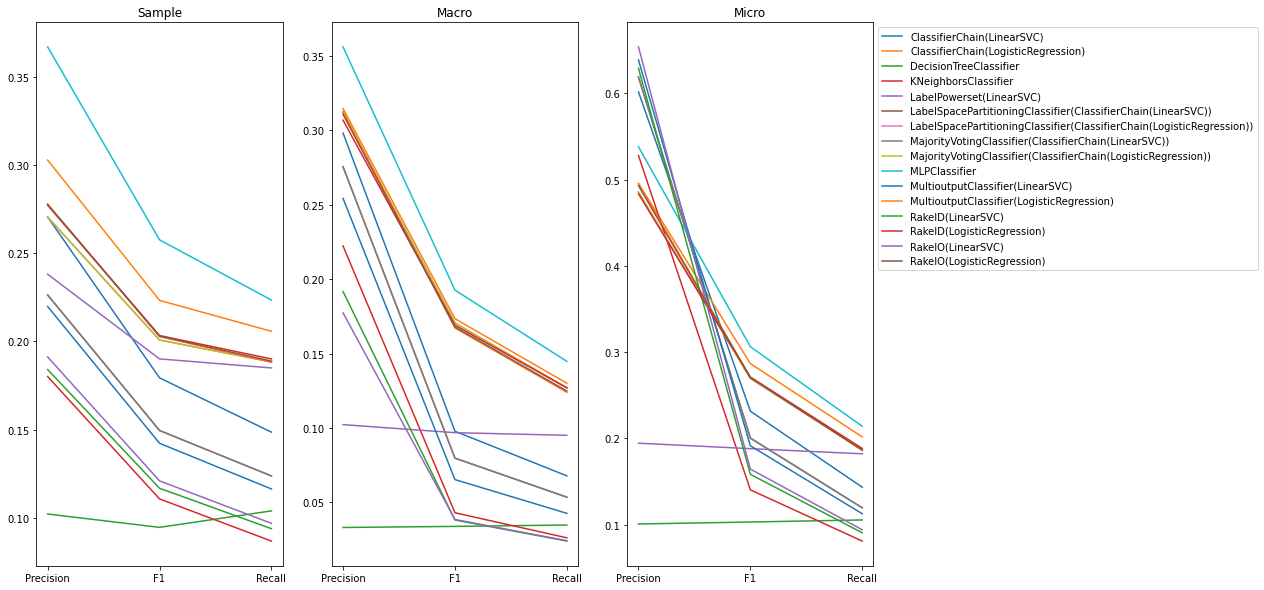

In [29]:
x_ = ['Precision', 'F1', 'Recall']
fig, axes = plt.subplots(1, 3, figsize=(15,10))
axes[0].set_title('Sample')
axes[1].set_title('Macro')
axes[2].set_title('Micro')
for eval_ in evals:
    evaluator = eval_[1]
    axes[0].plot(x_, [evaluator.precision_samples, evaluator.f1_samples, evaluator.recall_samples], label=eval_[0])
    axes[1].plot(x_, [evaluator.precision_macro, evaluator.f1_macro, evaluator.recall_macro], label=eval_[0])
    axes[2].plot(x_, [evaluator.precision_micro, evaluator.f1_micro, evaluator.recall_micro], label=eval_[0])
axes[2].legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()

In [30]:
top_3 = sorted(paths, key=lambda x: load(x).evaluation.recall_macro, reverse=True)[:3]

In [31]:
def per_label_accuracy(orig, prediction):
    if not isinstance(prediction, np.ndarray):
        prediction = prediction.toarray() 
    l = 1 - orig - prediction
    return np.average(l, axis=0)

In [32]:
from sklearn.metrics import classification_report
classwise_results = []
for clf_path in top_3:
    clf = load(clf_path)
    _, X_test_ = doc2vec(X_train, X_test)
    prediction = clf.predict(X_test_)
    label_accuracies = per_label_accuracy(y_test, prediction)
    report = classification_report(y_test, prediction, output_dict=True, zero_division=0)
    classwise_report = {}
    for i, result in enumerate(report):
        if i < len(label_accuracies):
            classwise_report[result] = report[result]
            classwise_report[result]['accuracy'] = label_accuracies[int(result)]
    classwise_results.append((clf, classwise_report))

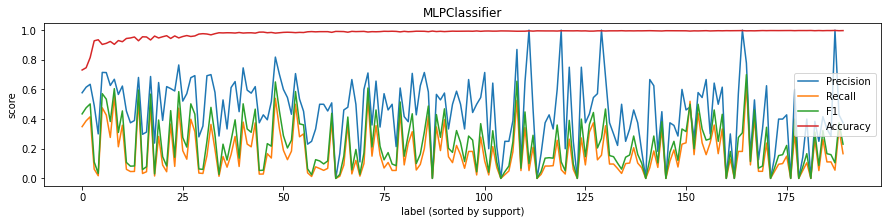

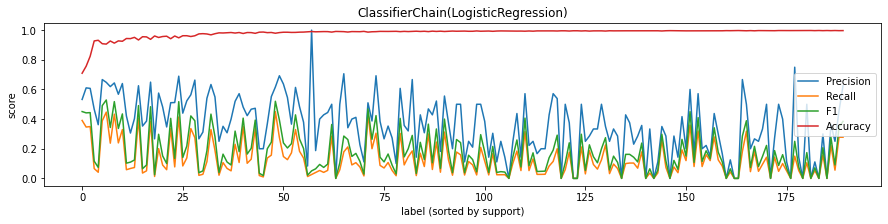

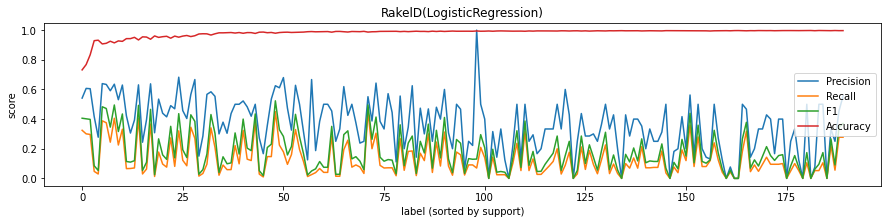

In [33]:
import numpy as np
x_ = np.arange(0, len(y_test[0]))
for classwise_result in classwise_results:
    name, results = classwise_result
    _, fig_1 = plt.subplots(figsize=(15,3))
    fig_1.set_title(name)
    sorted_results = sorted(results, key=lambda x: results[x]['support'], reverse=True)
    fig_1.plot(x_, [results[result]['precision'] for result in sorted_results], label='Precision')
    fig_1.plot(x_, [results[result]['recall'] for result in sorted_results], label='Recall')
    fig_1.plot(x_, [results[result]['f1-score'] for result in sorted_results], label='F1')
    fig_1.plot(x_, [results[result]['accuracy'] for result in sorted_results], label="Accuracy")
    fig_1.set_xlabel('label (sorted by support)')
    fig_1.set_ylabel('score')
    fig_1.legend(loc='best')
plt.show()

**Impact of vector size**

In [34]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)-param=100', 100)

Training: 33.20772576332092s
Test: 0.9706299304962158s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013308725259339401     0.05332527206771463      0.2601364616644864       0.17369810560257962      0.18896127222786302      
micro                                                            0.5025769605794679       0.17222779130268748      0.2565415244596132       
macro                                                            0.3028406617711371       0.10556824090361457      0.14890088877050278      


In [35]:
create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)-param=200', 200)

Training: 56.365275144577026s
Test: 1.60227370262146s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.014297715267612804     0.05634824667472793      0.321258374699409        0.24984885126964929      0.25144566837773286      
micro                                                            0.436061704459243        0.24693302782949067      0.31531147141289767      
macro                                                            0.27398979598507994      0.18879378243274209      0.2123860484920176       


In [36]:
create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)-param=500', 500)

Training: 203.8874237537384s
Test: 4.476989030838013s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.014929676064405269     0.05671100362756953      0.34595149459569047      0.28597944377267226      0.2786234898699101       
micro                                                            0.41267742833286947      0.2831161391951883       0.3358342062795504       
macro                                                            0.26209067181546153      0.2182013421160135       0.22841620282699648      


In [37]:
create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)-param=1000', 1000)

Training: 314.5471205711365s
Test: 7.171943664550781s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.014920129828804175     0.05538089480048368      0.3446612948734506       0.2876743248690044       0.27856031212594146      
micro                                                            0.4131690680030626       0.28335481407227076      0.33616491108845853      
macro                                                            0.26027758338144014      0.21289952645802926      0.22430323170572566      


In [39]:
paths = available_classifier_paths('doc2vec')
multi_names = ['MultioutputClassifier(LogisticRegression)-']
evals = []
for path in paths:
    if 'MultioutputClassifier(LogisticRegression)-' in str(path):
        clf = load(path)
        evaluation = clf.evaluation
        evals.append([int(str(clf.name_prefix).strip('MultioutputClassifier(LogisticRegression)-param=')), evaluation])

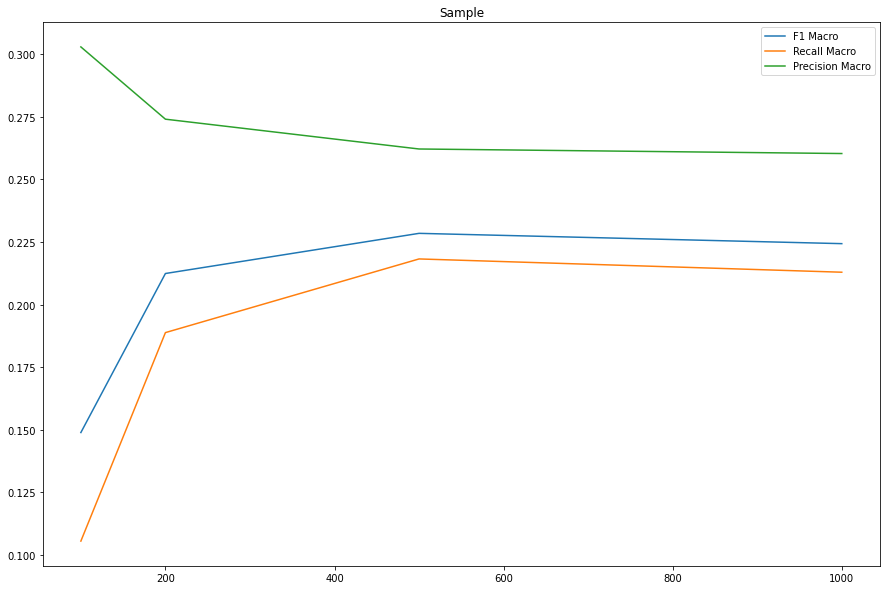

In [40]:
fig, axes = plt.subplots(figsize=(15,10))
axes.set_title('Sample')
evals = sorted(evals, key=lambda x: x[0])
x_ = [eval[0] for eval in evals]
axes.plot(x_, [eval[1].f1_macro for eval in evals], label='F1 Macro')
axes.plot(x_, [eval[1].recall_macro for eval in evals], label='Recall Macro')
axes.plot(x_, [eval[1].precision_macro for eval in evals], label='Precision Macro')
axes.legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()